In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from experiments_helper import run_experiments, format_df_table, summarize_results, get_data_model, get_action_set


In [60]:
def methods_naming(name):
    if "mapofcem" in name and "perm" in name:
        return "MAPOFCEM (Permutation)"
    elif "mapofcem" in name and "tree" in name:
        return "MAPOFCEM (Tree)"
    elif "mapofcem" in name and "deep" in name:
        return "MAPOFCEM (Deep)"
    if "mapofcem" in name:
        return "MAPOFCEM"
    elif "mapocam" in name:
        return "MAPOCAM"
    elif "dice" in name:
        return "DICE"
    elif "nice" in name:
        return "NICE"
    else:
        return name
    

def methods_coloring(name):
    if "mapofcem" in name and "perm" in name:
        return "#66c2a5"
    elif "mapofcem" in name and "tree" in name:
        return "#a6d854"
    elif "mapofcem" in name and "deep" in name:
        return "#8da0cb"
    elif "mapofcem" in name:
        return "#66c2a5"
    elif "mapocam" in name:
        return "#fc8d62"
    elif "dice" in name:
        return "#80b1d3"
    elif "nice" in name:
        return "#984ea3"
    else:
        return "#ff0000"
    
def dataset_naming(name):
    if name == "german":
        return "German Credit"
    elif name == "taiwan":
        return "Taiwan"
    elif name == "adult":
        return "Adult"
    else:
        return name

In [61]:
def plot_test(results, axs):
    outliers_ = []
    method_list = results.method.unique()
    min_x, max_x, min_y, max_y = np.inf, -np.inf, np.inf, -np.inf
    for method in method_list:
        results_r = results[results.method == method]
        x_mean = results_r.time.mean()
        y_mean = results_r.costs.mean()
        outliers_.append(results_r.outlier.mean())

        min_x = min(min_x, x_mean)
        max_x = max(max_x, x_mean)
        min_y = min(min_y, y_mean)
        max_y = max(max_y, y_mean)

        x_05 = x_mean - np.quantile(results_r.time, 0.05)
        x_95 = np.quantile(results_r.time, 0.95) - x_mean
        y_05 = y_mean - np.quantile(results_r.costs, 0.05)
        y_95 = np.quantile(results_r.costs, 0.95) - y_mean


        axs[0].scatter(
            x_mean, 
            y_mean, 
            label = methods_naming(method), 
            c = methods_coloring(method),
            zorder = 100 if "mapofcem" in method else 2,
        )
        axs[0].errorbar(
            [x_mean],
            [y_mean],
            xerr = [[x_05], [x_95]],
            yerr = [[y_05], [y_95]],
            label = methods_naming(method),
            c = methods_coloring(method),
            zorder = 100 if "mapofcem" in method else 2,
        )

    x_pad = (max_x - min_x) * 0.1
    y_pad = (max_y - min_y) * 0.1
    #axs[0].set_xlim(min_x - x_pad, max_x + x_pad)
    #axs[0].set_ylim(min_y - y_pad, max_y + y_pad)

    handles = [
        Line2D(
            [0],
            [0],
            marker = "o",
            color = "w",
            markerfacecolor =  methods_coloring(name),
            markersize = 10,
            label = methods_naming(name),
        ) for name in method_list
    ]
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Average Continuous Dist.")


    axs[1].barh(
        [methods_naming(name) for name in method_list],
        [o * 100 for o in outliers_],
        color = [methods_coloring(name) for name in method_list],
    )
    axs[1].set_xlabel("% Outliers")

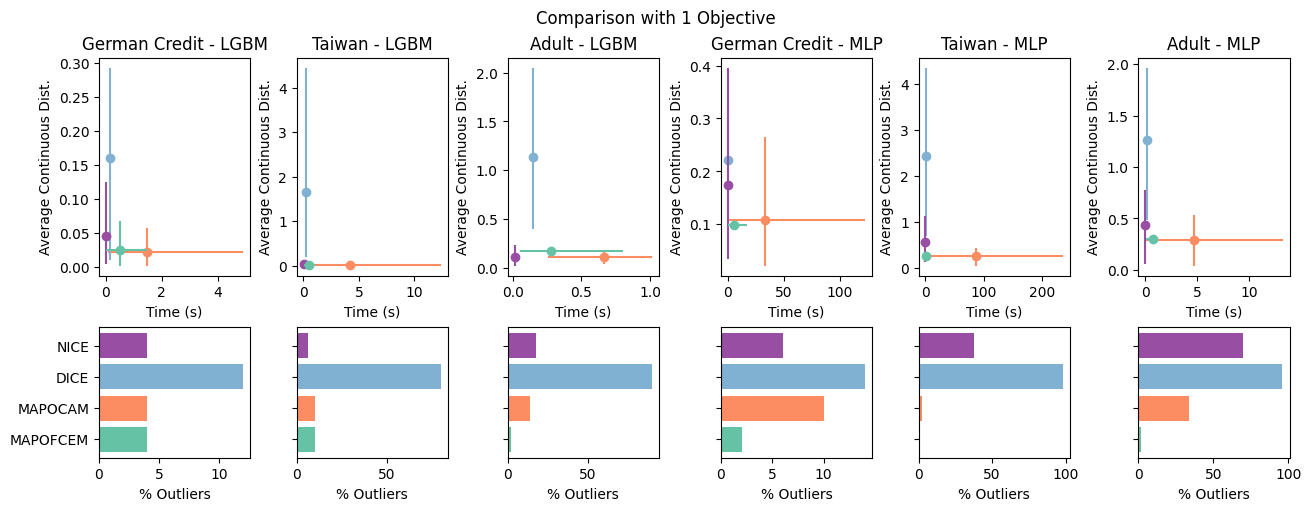

In [66]:
fig = plt.figure(figsize = (13, 5), layout = "constrained")
axs = fig.subplots(nrows = 2, ncols = 6, height_ratios=[1, 0.6])

for i, dataset_name in enumerate(["german", "taiwan", "adult"]):
    for j, model in enumerate(["lgbm", "mlp"]):
        results = []
        if model == "lgbm":
            method_list = ["mapofcem_tree_abs_diff", "mapocam_tree_abs_diff", "dice", "nice"]
        else:
            method_list = ["mapofcem_deep_abs_diff", "mapocam_abs_diff", "dice", "nice"]

        for method in method_list:
            try:
                results_cur = pd.read_csv(f"../results/{model}/{dataset_name}/{method}.csv")
                results_cur = summarize_results(results_cur, dataset_name)

                if "mapofcem" in method:
                    method = "mapofcem_abs_diff"
                if "mapocam" in method:
                    method = "mapocam_abs_diff"
                    
                results_cur["method"] = method
                results.append(results_cur)
            except:
                pass
        
        results = pd.concat(results)
        results["costs"] = results["abs_diff_costs"]
        axs_ = [axs[0][j * 3 + i], axs[1][j * 3 + i]]
        plot_test(results, axs_)

        axs[0][j * 3 + i].set_title(f"{dataset_naming(dataset_name)} - {model.upper()}")

for i in range(1, 6):
    axs[1][i].set_yticklabels([])

plt.suptitle("Comparison with 1 Objective")
plt.savefig("../figures/percentile_results.pdf", dpi = 300)

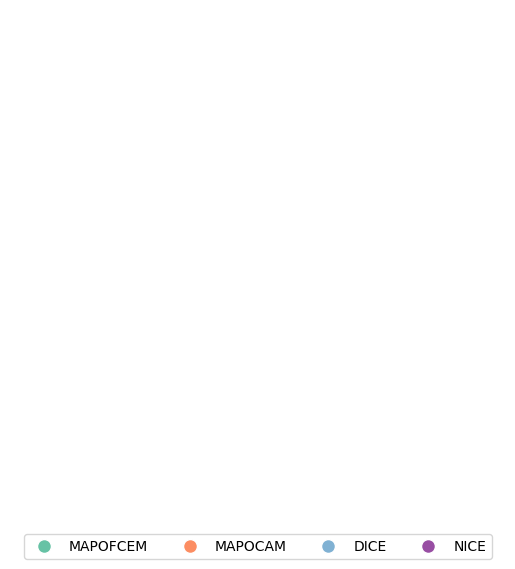

In [64]:
# plot the legend separately

fig = plt.figure()
handles = [
    Line2D(
        [0],
        [0],
        marker = "o",
        color = "w",
        markerfacecolor =  methods_coloring(name),
        markersize = 10,
        label = methods_naming(name),
    ) for name in results.method.unique()
]

plt.axis("off")
plt.legend(handles=handles, ncol = len(handles), loc='upper center', bbox_to_anchor=(0.5, -0.4),)
plt.savefig("../figures/percentile_legend.pdf", dpi = 300)